In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("taruntiwarihp/phishing-site-urls")

print("Path to dataset files:", path)

Path to dataset files: /home/n1ved/.cache/kagglehub/datasets/taruntiwarihp/phishing-site-urls/versions/1


In [10]:
import pandas as pd
df = pd.read_csv('/home/n1ved/.cache/kagglehub/datasets/taruntiwarihp/phishing-site-urls/versions/1/phishing_site_urls.csv')
print("Columns:", df.columns.tolist())  # Verify actual column names

# Universal implementation
X = df.drop(['URL', 'Label'], axis=1)  # Drop both URL string and label
y = df['Label']  # Use actual label column name

# Verify class distribution
print("\nClass balance:")
print(y.value_counts())


Columns: ['URL', 'Label']

Class balance:
Label
good    392924
bad     156422
Name: count, dtype: int64


In [11]:
# PhishStorm encoding check [5]
print("Sample labels:", df[['URL', 'Label']].head(2))


Sample labels:                                                  URL Label
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# If using raw URLs as features
vectorizer = TfidfVectorizer(max_features=500)
X_url_features = vectorizer.fit_transform(df['URL'])


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_url_features,  # or X if using engineered features
    y,
    test_size=0.25,
    stratify=y
)

# Train model
model = RandomForestClassifier(
    n_estimators=150,
    max_depth=12,
    class_weight='balanced'
)
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=150)

              precision    recall  f1-score   support

         bad       0.76      0.71      0.73     39106
        good       0.89      0.91      0.90     98231

    accuracy                           0.85    137337
   macro avg       0.83      0.81      0.82    137337
weighted avg       0.85      0.85      0.85    137337


AUC-ROC: 0.89


<Axes: >

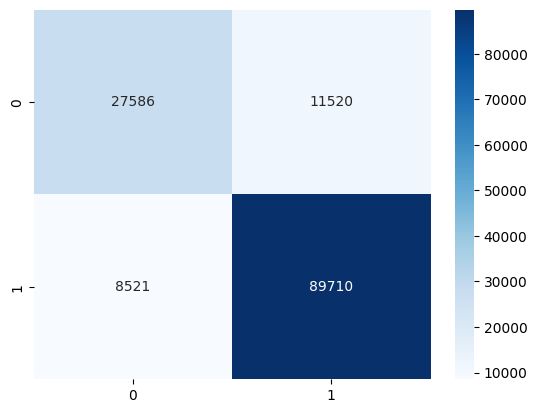

In [17]:
from sklearn.metrics import classification_report, roc_auc_score
# Essential imports for confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay  # For visualization [3][5]


# Basic metrics
print(classification_report(y_test, model.predict(X_test)))

# AUC-ROC for class imbalance assessment
probabilities = model.predict_proba(X_test)[:, 1]
print(f"\nAUC-ROC: {roc_auc_score(y_test, probabilities):.2f}")

# Confusion matrix visualization
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, model.predict(X_test)), 
            annot=True, fmt='d', cmap='Blues')


In [18]:
joblib.dump(model, 'phishing_rf_v1.pkl')

['phishing_rf_v1.pkl']

In [19]:
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import joblib

class URLValidator:
    def __init__(self):
        self.vectorizer = joblib.load('tfidf_vectorizer.pkl')
        self.model = joblib.load('phishing_model.pkl')
        
    def extract_structural_features(self, url):
        """Extract manual URL structure features"""
        parsed = urlparse(url)
        return {
            'url_length': len(url),
            'num_digits': sum(c.isdigit() for c in url),
            'uses_https': 1 if parsed.scheme == 'https' else 0,
            'has_port': 1 if parsed.port else 0,
            'subdomain_count': parsed.hostname.count('.') - 1 if parsed.hostname else 0
        }
    
    def predict(self, url):
        # Extract structural features
        structural_features = self.extract_structural_features(url)  # DEFINE HERE
        
        # Generate text features
        text_features = self.vectorizer.transform([url])
        
        # Create DataFrames with string column names
        structural_df = pd.DataFrame([structural_features]).add_prefix('struct_')
        text_df = pd.DataFrame(text_features.toarray(), 
                             columns=[f"tfidf_{f}" for f in self.vectorizer.get_feature_names_out()])
        
        # Combine features
        X = pd.concat([structural_df, text_df], axis=1)
        X.columns = X.columns.astype(str)  # Force all columns to string type
        
        pred = self.model.predict(X)
        return 'Phishing' if pred[0] == 1 else 'Legitimate'


In [38]:
test_urls = [
    "https://www.paypal.com/login?secure=true",
    "http://azlyrics.com.secure-login-verify.net",
    "https://github.com/n1ved/security-tools"
]

for url in test_urls:
    print(f"{url}\n→ {validator.predict(url)}\n")


NameError: name 'structural_features' is not defined

In [39]:
# After feature engineering during training
structural_df = pd.json_normalize(df['URL'].apply(extract_structural_features)).add_prefix('struct_')
tfidf_features = pd.DataFrame(
    vectorizer.transform(df['URL']).toarray(),
    columns=[f"tfidf_{f}" for f in vectorizer.get_feature_names_out()]
)
X = pd.concat([structural_df, tfidf_features], axis=1)


NameError: name 'extract_structural_features' is not defined